# ***Setup***

In [ ]:
!pip install emcee
!pip install corner
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 812.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pymc as pm
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
import pandas as pd
import seaborn as sns
import scipy.optimize as op
import corner
import warnings
from matplotlib.colors import LogNorm
import warnings
import pandas as pd
from scipy.optimize import minimize
import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
data = pd.read_csv('average_mass_by_redshift.csv')
observed_mass = data['Mass'].values
x = data['Redshift'].values

In [ ]:
for i in range(100):
    file_path = f'/content/branch{i}.csv'
    df = pd.read_csv(file_path)
    z = df['z']
    mass = df['mass']

In [ ]:
Omm = 0.266
Omk = 0
Oml = 0.734
Omb = 0.049

# ***Functions***

In [ ]:
def t(dark_matter_z_values):
    return 1e9 * Planck15.age(dark_matter_z_values).value

def M_halo(dark_matter_z_values, dark_matter_mass_values):
    return dark_matter_mass_values

def evolve_bh(dark_matter_z_values,dark_matter_mass_values, M_i, tau_fold, f_bh, cap=True):
    total_baryons = f_bh * (Omb / Omm) * M_halo(dark_matter_z_values, dark_matter_mass_values)
    maximum_bh_mass = total_baryons
    bh_mass = np.array([M_i])


    for x in range(len(dark_matter_z_values) - 1):
        current_time = t(dark_matter_z_values[x])
        next_time = t(dark_matter_z_values[x + 1])
        dt = next_time - current_time
        scale_factor = np.exp(dt / tau_fold)
        current_bh_mass = bh_mass[-1]

        # Add random fluctuations to the growth factor
        growth_factor = np.random.uniform(0.9, 1.1)
        next_bh_mass = current_bh_mass * scale_factor * growth_factor

        if cap and next_bh_mass > maximum_bh_mass[x + 1]:
            next_bh_mass = maximum_bh_mass[x + 1]
        elif next_bh_mass <= current_bh_mass:  # Ensure strictly increasing black hole mass
            next_bh_mass = current_bh_mass + np.finfo(float).eps  # Add smallest representable value

        if next_bh_mass <= bh_mass[-1]:
            next_bh_mass = bh_mass[-1] + np.finfo(float).eps  # Add smallest representable value

        bh_mass = np.append(bh_mass, next_bh_mass)

    return bh_mass

In [ ]:
def evl_growth(dark_matter_z_values, dark_matter_mass_values, M_i, f_bh, tau_fold):
    evl_z_list = []
    evl_mass_list = []

    for i in range(100):
        file_path = f'/content/branch{i}.csv'
        df = pd.read_csv(file_path)
        dark_matter_mass_values = df['mass']
        dark_matter_z_values = df['z']
        evolved_mass = evolve_bh(dark_matter_z_values, dark_matter_mass_values, M_i, tau_fold, f_bh, cap=True)
        evl_z_list.extend(dark_matter_z_values)  # Use dark_matter_z_values instead of z
        evl_mass_list.extend(evolved_mass)

    evl_data = pd.DataFrame({'Redshift': evl_z_list, 'Evolved_Mass': evl_mass_list})
    return evl_data

In [ ]:
def median_growth(dark_matter_z_values, dark_matter_mass_values, M_i, f_bh, tau_fold):
    z_list = []
    median_mass_list = []

    for i in range(100):
        file_path = f'/content/branch{i}.csv'
        df = pd.read_csv(file_path)
        dark_matter_mass_values = df['mass']
        dark_matter_z_values = df['z']
        evolved_mass = evolve_bh(dark_matter_z_values, dark_matter_mass_values, M_i, tau_fold, f_bh, cap=True)
        z_list.extend(dark_matter_z_values)
        median_mass_list.extend(evolved_mass)

    median_data = pd.DataFrame({'Redshift': z_list, 'Evolved_Mass': median_mass_list})
    median_mass_by_redshift = median_data.groupby('Redshift')['Evolved_Mass'].median().reset_index()

    # Sort the data by redshift to ensure increasing order
    median_mass_by_redshift = median_mass_by_redshift.sort_values('Redshift')

    return median_mass_by_redshift

In [ ]:
def interpolated_median_growth(dark_matter_z_values, dark_matter_mass_values, M_i, f_bh, tau_fold):
    z_list = []
    median_mass_list = []

    for i in range(100):
        file_path = f'/content/branch{i}.csv'
        df = pd.read_csv(file_path)
        dark_matter_mass_values = df['mass']
        dark_matter_z_values = df['z']
        evolved_mass = evolve_bh(dark_matter_z_values, dark_matter_mass_values, M_i, tau_fold, f_bh, cap=True)
        z_list.extend(dark_matter_z_values)
        median_mass_list.extend(evolved_mass)

    median_data = pd.DataFrame({'Redshift': z_list, 'Evolved_Mass': median_mass_list})
    median_mass_by_redshift = median_data.groupby('Redshift')['Evolved_Mass'].median().reset_index()

    # Sort the data by redshift to ensure increasing order
    median_mass_by_redshift = median_mass_by_redshift.sort_values('Redshift')

    # Perform linear interpolation to get the predicted mass for observed redshifts
    interp_function = interp1d(median_mass_by_redshift['Redshift'], median_mass_by_redshift['Evolved_Mass'],
                               kind='linear', fill_value='extrapolate')
    predicted_mass_for_observed_z = interp_function(observed_z)

    return predicted_mass_for_observed_z

In [ ]:
M_i = 1e5
tau_fold_guess = 47e6
f_bh_guess = 0.1

# ***MCMC***

In [ ]:
def y_pred(x_values, halo_mass_values, folding_time, fraction_cap):
    dt = x_values[1:] - x_values[:-1]
    scale_factor = np.exp(dt / folding_time*120e6)
    cap = fraction_cap * halo_mass_values * Omb / Omm

    bh_mass = [seed if seed <= cap[0] else cap[0]]

    for i, sf in enumerate(scale_factor[:-1]):
        old_mass = bh_mass[i]
        growth = old_mass * sf
        c = cap[i]

        if growth <= c:
            bh_mass.append(growth)
        elif c > old_mass:
            bh_mass.append(c)
        else:
            bh_mass.append(old_mass)
    return cap

In [ ]:
tau_fold_true = 0.3
f_bh_true = 0.1
f_true = 0.5
err = np.random.normal(scale=.1, size=observed_mass.shape)

In [ ]:
def ln_prior(params):
    f_bh, tau_fold = params

    if ((0.05 < f_bh < 0.5) and ( 0.125 < tau_fold < 0.5)):
        return 0.0  # Prior within the constraints

    return -np.inf  # Prior outside the constraints

def ln_likelihood(params):
    f_bh, tau_fold = params
    ln_likelihood_sum = 0.0  # Initialize the likelihood sum

    model = y_pred(x, int_halo_mass, folding_time, fraction_cap)
    residuals = observed_mass - model # <-- Corrected this line
    sigma_sq =100
    chi_squared = np.sum(residuals ** 2 / sigma_sq)
    ln_likelihood_sum += -0.5 * chi_squared  # Accumulate the likelihood sum

    return ln_likelihood_sum

def ln_posterior(params):
    ln_prior_val = ln_prior(params)

    if np.isinf(ln_prior_val):
        return ln_prior_val  # Return -inf if outside the prior constraints

    ln_likelihood_val = ln_likelihood(params)
    ln_posterior_val = ln_prior_val + ln_likelihood_val

    return ln_posterior_val

nwalkers = 1000
ndim = 2
p0 = np.random.rand(nwalkers, ndim)

# Create an instance of the emcee.EnsembleSampler class
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior)

# Run the MCMC sampling
nsteps = 5000
burnin = 1000
samples = np.zeros((nwalkers, nsteps - burnin, ndim))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract the samples after the burn-in period
samples = sampler.get_chain(discard=burnin, thin=15, flat=True)  # Thin for better mixing

# Extract the posterior samples for each parameter
f_bh_samples = samples[:, 0]  # Samples for f_bh
tau_fold_samples = samples[:, 1]  # Samples for tau_fold

emcee: Exception while calling your likelihood function:
  params: [0.33416861 0.24015892]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-18-714043fe8eeb>", line 27, in ln_posterior
    ln_likelihood_val = ln_likelihood(params)
  File "<ipython-input-18-714043fe8eeb>", line 13, in ln_likelihood
    model = y_pred(x, int_halo_mass, folding_time, fraction_cap)
NameError: name 'int_halo_mass' is not defined


NameError: ignored

In [ ]:
labels = ["f_bh", "tau_fold"]
samples_for_corner_plot = np.column_stack((f_bh_samples, tau_fold_samples))

corner_plot = corner.corner(
    samples_for_corner_plot,
    labels=labels,
    truths=[f_bh_true, tau_fold_true],  # If you have true parameter values
    quantiles=[0.16, 0.5, 0.84],  # Show median and 1-sigma intervals
    show_titles=True,  # Display 1D histograms on the diagonal
)

plt.show()

# ***Visualize***

In [ ]:
median_data = median_growth(z, mass, M_i, f_bh_guess, tau_fold_guess)
evl_data = evl_growth(z, mass, M_i, f_bh_guess, tau_fold_guess)
plt.figure(figsize=(6, 5))
plt.plot(median_data['Redshift'], median_data['Evolved_Mass'], label='Continuous Median Growth', color='b',linewidth = 2)
plt.plot()
plt.scatter(evl_data['Redshift'], evl_data['Evolved_Mass'],s=5, label='Single Branch Growth', c='r')
plt.yscale('log')
plt.xlabel('Redshift [z]')
plt.ylabel('$M \ [M_{\odot}]$')
plt.title('Evolved Mass as a function of Redshift')
plt.legend()
plt.grid(True)

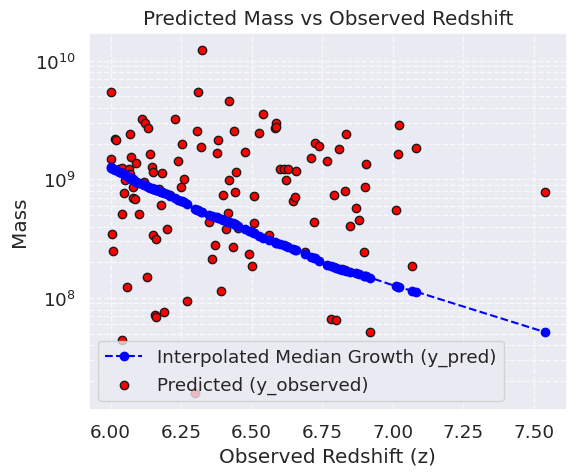

In [ ]:
predicted_mass = interpolated_median_growth(observed_z, observed_mass, 1e5, f_bh_guess, 75e6)

plt.figure(figsize=(6, 5))
plt.plot(observed_z, predicted_mass, marker='o', markersize=6, linestyle='--', color='blue', label='Interpolated Median Growth (y_pred)')
plt.scatter(observed_z, observed_mass, label='Predicted (y_observed)', c='red', marker='o', edgecolors='k')
plt.xlabel('Observed Redshift (z)')
plt.ylabel('Mass')
plt.title('Predicted Mass vs Observed Redshift')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
observed_mass.shape

# ***PYmc***

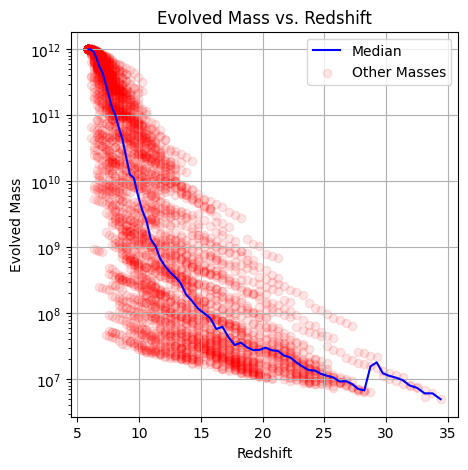

In [ ]:
z_list = []
median_mass_list = []

for i in range(100):
    file_path = f'/content/branch{i}.csv'
    df = pd.read_csv(file_path)
    halo_mass = df['mass']
    halo_z = df['z']
    z_list.extend(halo_z)
    median_mass_list.extend(halo_mass)

median_data = pd.DataFrame({'Redshift': z_list, 'Evolved_Mass': median_mass_list})
halo_median_mass = median_data.groupby('Redshift')['Evolved_Mass'].median().reset_index()
halo_median_mass = halo_median_mass.sort_values('Redshift')

# Plot median evolved mass
plt.figure(figsize=(5, 5))
plt.plot(halo_median_mass['Redshift'], halo_median_mass['Evolved_Mass'], color='blue', label='Median')

# Plot other masses
for i in range(100):
    file_path = f'/content/branch{i}.csv'
    df = pd.read_csv(file_path)
    plt.scatter(df['z'], df['mass'], color='red', alpha=0.1)

plt.xlabel("Redshift")
plt.ylabel("Evolved Mass")
plt.title("Evolved Mass vs. Redshift")
plt.yscale('log')
plt.grid(True)
plt.legend(['Median', 'Other Masses'])
plt.show()

In [ ]:
halo_mass = halo_median_mass['Evolved_Mass']
halo_z = halo_median_mass['Redshift']

# ***RMS***

In [ ]:
N_GRID = 20
tau_fold_list = np.linspace(30e6, 120e6, N_GRID)
f_bh_list = np.linspace(0.05, 0.5, N_GRID)
seed = 1e5

all_branches = []
for i in range(100):
    filename = f"branch{i}.csv"
    data = pd.read_csv(filename)
    mass_values = data["mass"].values
    z_values = data["z"].values
    all_branches.append((z_values, mass_values))

tau_grid, f_grid, rms_grid = [], [], []

for tau_fold in tau_fold_list:
    for f_bh in f_bh_list:

        all_bh_z, all_bh_mass = [], []

        for branch_data in all_branches:
            bh_mass_result = evolve_bh(branch_data[0], branch_data[1], seed, tau_fold, f_bh, cap=True)
            bh_mass = bh_mass_result
            all_bh_z.extend(branch_data[0])
            all_bh_mass.extend(bh_mass)

        all_bh_z, all_bh_mass = np.array(all_bh_z), np.array(all_bh_mass)
        unique_z = np.sort(np.unique(all_bh_z))

        bh_mean = []

        for z_val in unique_z:
            args = np.where(all_bh_z == z_val)[0]
            bh_mean.append(np.mean(all_bh_mass[args]))

        interp_function = interp1d(unique_z, bh_mean, kind='linear')
        interped_bh_mass = interp_function(observed_z)

        rms = np.sqrt(np.mean(np.power(interped_bh_mass - observed_mass, 2)))
        rms_grid.append(rms)
        tau_grid.append(tau_fold)
        f_grid.append(f_bh)

tau_grid, f_grid, rms_grid = np.array(tau_grid), np.array(f_grid), np.array(rms_grid)
rms_grid = np.log10(rms_grid)

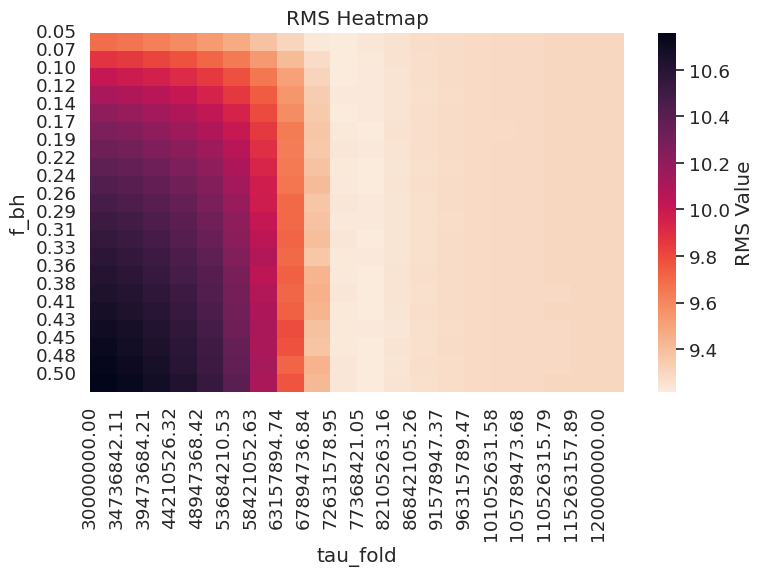

In [ ]:
heatmap_data = pd.DataFrame({'tau_fold': tau_grid, 'f_bh': f_grid, 'rms': rms_grid})
heatmap_data_pivot = heatmap_data.pivot(index='f_bh', columns='tau_fold', values='rms')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(heatmap_data_pivot, fmt=".3f", cmap="rocket_r", cbar_kws={'label': 'RMS Value'})

# Set custom ticks for both axes
tau_fold_ticks = np.linspace(min(tau_grid), max(tau_grid), N_GRID)
f_bh_ticks = np.linspace(min(f_grid), max(f_grid), N_GRID)

plt.yticks(np.arange(N_GRID), ["{:.2f}".format(val) for val in f_bh_ticks])
plt.xticks(np.arange(N_GRID), ["{:.2f}".format(val) for val in tau_fold_ticks])

plt.ylabel('f_bh')
plt.xlabel('tau_fold')
plt.title('RMS Heatmap')
plt.tight_layout()

plt.show()

In [ ]:
N_GRID = 20
tau_fold_list = np.linspace(72e6, 120e6, N_GRID)
f_bh_list = np.linspace(0.05, 0.5, N_GRID)
seed = 1e5

all_branches = []
for i in range(100):
    filename = f"branch{i}.csv"
    data = pd.read_csv(filename)
    mass_values = data["mass"].values
    z_values = data["z"].values
    all_branches.append((z_values, mass_values))

tau_grid, f_grid, rms_grid = [], [], []

for tau_fold in tau_fold_list:
    for f_bh in f_bh_list:

        all_bh_z, all_bh_mass = [], []

        for branch_data in all_branches:
            bh_mass_result = evolve_bh(branch_data[0], branch_data[1], seed, tau_fold, f_bh, cap=True)
            bh_mass = bh_mass_result
            all_bh_z.extend(branch_data[0])
            all_bh_mass.extend(bh_mass)

        all_bh_z, all_bh_mass = np.array(all_bh_z), np.array(all_bh_mass)
        unique_z = np.sort(np.unique(all_bh_z))

        bh_mean = []

        for z_val in unique_z:
            args = np.where(all_bh_z == z_val)[0]
            bh_mean.append(np.mean(all_bh_mass[args]))

        interp_function = interp1d(unique_z, bh_mean, kind='linear')
        interped_bh_mass = interp_function(observed_z)

        rms = np.sqrt(np.mean(np.power(interped_bh_mass - observed_mass, 2)))
        rms_grid.append(rms)
        tau_grid.append(tau_fold)
        f_grid.append(f_bh)

tau_grid, f_grid, rms_grid = np.array(tau_grid), np.array(f_grid), np.array(rms_grid)
rms_grid = np.log10(rms_grid)

KeyboardInterrupt: ignored

In [ ]:
heatmap_data = pd.DataFrame({'tau_fold': tau_grid, 'f_bh': f_grid, 'rms': rms_grid})
heatmap_data_pivot = heatmap_data.pivot(index='f_bh', columns='tau_fold', values='rms')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(heatmap_data_pivot, fmt=".3f", cmap="rocket_r", cbar_kws={'label': 'RMS Value'})

# Set custom ticks for both axes
tau_fold_ticks = np.linspace(min(tau_grid), max(tau_grid), N_GRID)
f_bh_ticks = np.linspace(min(f_grid), max(f_grid), N_GRID)

plt.yticks(np.arange(N_GRID), ["{:.2f}".format(val) for val in f_bh_ticks])
plt.xticks(np.arange(N_GRID), ["{:.2f}".format(val) for val in tau_fold_ticks])

plt.ylabel('f_bh')
plt.xlabel('tau_fold')
plt.title('RMS Heatmap')
plt.tight_layout()

plt.show()